In [2]:
import sys
import os
import pickle
from tqdm import tqdm
from topolearn import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")


In [4]:
prob_T=0.6

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1] # N2
nd = B1.shape[1] # N1
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu_true, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = B2@G.mask
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity_mode = "random"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.array([15])
K0_max = 25
max_iter = 100 
patience = 5 
tol = 1e-3 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

T_coll = [0.5, 0.6, 0.7, 0.8, 0.9]

In [5]:
gen_params = {
        "dictionary_type": dictionary_type,
        "m_train": m_train,
        "m_test": m_test,
        "P": P,
        "M": M,
        "J": J,
        "K0_max": K0_max,
        "sparsity_mode": sparsity_mode,
        "n_search": n_search,
        "n_sim": n_sim,
    }

init_params = {
    "J": J,
    "P": P,
    "true_prob_T": prob_T,
    "n": B1.shape[0],
    "sparsity": 25,
    "B1_true": B1,
    "B2_true": B2_true
}

algo_params = {
    "lambda_": 1e-7,
    "tol": 1e-7,
    "patience": 5,
    "max_iter": 100,
    "QP": True,
    "mode": "optimistic",
    "warmup": 2,
    "on_test": False,
    "complete": True,
    "verbose": True,
}

min_error_complete_train = np.zeros((n_sim, len(T_coll)))
min_error_complete_test = np.zeros((n_sim, len(T_coll)))
approx_comp = np.zeros((n_sim, len(T_coll)))


In [57]:
# with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\synthetic_data\\random_sparsity25\\full_data_separated.pkl", "rb") as file:
#     data = pickle.load(file)


dict_errors = {
    "complete": (min_error_complete_train, min_error_complete_test, approx_comp),
}

dict_errors2 = {
    "complete": min_error_complete_test,
}

dict_types = {
    "complete": ("Separated Hodge Laplacian with Topology learning","separated"),
}

models = {}

for sim in tqdm(range(n_sim)):

    for k0_index, k0 in tqdm(enumerate(K0_coll), leave=False):

        for p_index, p in enumerate(T_coll):
            models[eval(f"{sim},{p_index}")] = []

            G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=p, seed=0)
            Lu, Ld, L = G.get_laplacians(sub_size=100)
            gen_params["prob_T"] = p
            print("Generating data...")
            load_data = generate_data(Lu, Ld, **gen_params)
            print("Data generating process complete!")

            # D_true = load_data["D_true"]
            Y_train = load_data["Y_train"]
            Y_test = load_data["Y_test"]
            X_train = load_data["X_train"]
            X_test = load_data["X_test"]
            epsilon_true = load_data["epsilon_true"]
            c_true = load_data["c_true"]

            for d in dict_types.items():

                model = TopoSolver(
                    X_train=X_train[:, :, sim],
                    X_test=X_test[:, :, sim],
                    Y_train=Y_train[:, :, sim],
                    Y_test=Y_test[:, :, sim],
                    c=c_true[sim],
                    epsilon=epsilon_true[sim],
                    K0=k0,
                    dictionary_type=d[1][1],
                    **init_params,
                )

                opt = False
                learn_topology = True if "complete" in d[0] else False
                if "pess" in d[0]:
                    algo_params["mode"] = "pessimistic"
                else:
                    algo_params["mode"] = "optimistic"
                    opt = True

                (
                    dict_errors[d[0]][0][sim,p_index],
                    dict_errors[d[0]][1][sim,p_index],
                    dict_errors[d[0]][2][sim,p_index],
                ) = model.fit(
                    Lu_true=Lu,
                    init_mode="only_X",
                    learn_topology=learn_topology,
                    **algo_params,
                )

                if opt:
                    models[eval(f"{sim},{p_index}")].append(model)

                if verbose:
                    print(
                        f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][sim, p_index]:.3f}"
                    )
                    print(
                        f"Topology Approx. Error: {dict_errors[d[0]][2][sim, p_index]:.3f}"
                    )


# with open(f"C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\real\\real_J{J}P{P}.pkl", "wb") as file:
#     pickle.dump(models, file)
#     pickle.dump(dict_errors, file)

  0%|          | 0/10 [00:00<?, ?it/s]

Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 20.000 !
Removing 2 triangles from the topology... 
 ... The min error: 15.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.014 !
Simulation: 1/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.014
Topology Approx. Error: 5.196
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 14.000 !
Removing 2 triangles from the topology... 
 ... The min error: 14.000 !
Simulation: 1/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 3.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 28.000 !
Removing 2 triangles from the topology... 
 ... The min error: 28.000 !
Removing 3 triangles from the topology... 
 ... Th

 10%|█         | 1/10 [21:01<3:09:13, 1261.45s/it]

Simulation: 1/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.018
Topology Approx. Error: 14.933


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 19.000 !
Simulation: 2/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.017
Topology Approx. Error: 7.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 14.000 !
Removing 2 triangles from the topology... 
 ... The min error: 14.000 !
Simulation: 2/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.014
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 33.000 !
Simulation: 2/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.030
Topology Approx. Error: 7.746
Generating data...
Data generating process complete!
Simulation: 2/10 Sparsity: 15 Testing Separated Hodge Laplacian with

 20%|██        | 2/10 [27:52<1:41:29, 761.17s/it] 

Simulation: 2/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.041
Topology Approx. Error: 14.422


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 10.000 !
Removing 2 triangles from the topology... 
 ... The min error: 8.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.008 !
Removing 4 triangles from the topology... 
 ... The min error: 0.008 !
Removing 5 triangles from the topology... 
 ... The min error: 0.007 !
Removing 6 triangles from the topology... 
 ... The min error: 0.006 !
Simulation: 3/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Simulation: 3/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.010
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 35.000 !
Removing 2 triangles from the topology... 
 ... The mi

 30%|███       | 3/10 [50:37<2:00:56, 1036.71s/it]

Simulation: 3/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.027
Topology Approx. Error: 15.133


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 12.000 !
Removing 2 triangles from the topology... 
 ... The min error: 10.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.010 !
Removing 4 triangles from the topology... 
 ... The min error: 0.010 !
Removing 5 triangles from the topology... 
 ... The min error: 0.009 !
Removing 6 triangles from the topology... 
 ... The min error: 0.008 !
Simulation: 4/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.005
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 18.000 !
Removing 2 triangles from the topology... 
 ... The min error: 14.000 !
Simulation: 4/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.013
Topology Approx. Error: 0.000
Generating data...
Data generating

 40%|████      | 4/10 [1:01:04<1:27:31, 875.29s/it]

Simulation: 4/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.045
Topology Approx. Error: 14.422


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 14.000 !
Removing 2 triangles from the topology... 
 ... The min error: 14.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.015 !
Removing 4 triangles from the topology... 
 ... The min error: 0.012 !
Simulation: 5/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.011
Topology Approx. Error: 4.243
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 9.000 !
Removing 2 triangles from the topology... 
 ... The min error: 9.000 !
Simulation: 5/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.007
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 32.000 !
Simulation: 5/10 Sparsity: 15 Testing Separated Hodge

 50%|█████     | 5/10 [1:10:14<1:03:08, 757.73s/it]

Simulation: 5/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.068
Topology Approx. Error: 14.422


Generating data...
Data generating process complete!
Simulation: 6/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.026
Topology Approx. Error: 7.616
Generating data...
Data generating process complete!
Simulation: 6/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.021
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 36.000 !
Removing 2 triangles from the topology... 
 ... The min error: 36.000 !
Simulation: 6/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.034
Topology Approx. Error: 7.746
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 32.000 !
Removing 2 triangles from the topology... 
 ... The min error: 32.000 !
Simulation: 6/10 Sparsity: 15 Testing Separated Hodge Laplacian with

 60%|██████    | 6/10 [1:16:43<42:09, 632.44s/it]  

Simulation: 6/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.065
Topology Approx. Error: 14.422


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 25.000 !
Removing 2 triangles from the topology... 
 ... The min error: 24.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.020 !
Removing 4 triangles from the topology... 
 ... The min error: 0.019 !
Removing 5 triangles from the topology... 
 ... The min error: 0.017 !
Simulation: 7/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.020
Topology Approx. Error: 3.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 15.000 !
Simulation: 7/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.012
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Simulation: 7/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.029
Topology A

 70%|███████   | 7/10 [1:25:28<29:51, 597.29s/it]

Simulation: 7/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.039
Topology Approx. Error: 14.422


Generating data...
Data generating process complete!
Simulation: 8/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 7.616
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 18.000 !
Removing 2 triangles from the topology... 
 ... The min error: 18.000 !
Simulation: 8/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Simulation: 8/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.024
Topology Approx. Error: 7.746
Generating data...
Data generating process complete!
Simulation: 8/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.037
Topology Approx. Error: 11.045
Generating data...
Data generating process complete!
Removing 1 tri

 80%|████████  | 8/10 [1:32:07<17:48, 534.31s/it]

Simulation: 8/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.032
Topology Approx. Error: 15.427


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 10.000 !
Removing 2 triangles from the topology... 
 ... The min error: 9.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.009 !
Removing 4 triangles from the topology... 
 ... The min error: 0.009 !
Removing 5 triangles from the topology... 
 ... The min error: 0.009 !
Simulation: 9/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.008
Topology Approx. Error: 3.000
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 13.000 !
Removing 2 triangles from the topology... 
 ... The min error: 13.000 !
Simulation: 9/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.013
Topology Approx. Error: 0.000
Generating data...
Data generating process complete!
Simulation: 9/10 Sparsity: 15 Testing Separated Hodge

 90%|█████████ | 9/10 [1:42:22<09:19, 559.59s/it]

Simulation: 9/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.021
Topology Approx. Error: 14.933


Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 12.000 !
Removing 2 triangles from the topology... 
 ... The min error: 12.000 !
Simulation: 10/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.014
Topology Approx. Error: 6.325
Generating data...
Data generating process complete!
Removing 1 triangles from the topology... 
 ... The min error: 6.000 !
Removing 2 triangles from the topology... 
 ... The min error: 6.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.006 !
Removing 4 triangles from the topology... 
 ... The min error: 0.006 !
Removing 5 triangles from the topology... 
 ... The min error: 0.006 !
Removing 6 triangles from the topology... 
 ... The min error: 0.006 !
Removing 7 triangles from the topology... 
 ... The min error: 0.006 !
Removing 8 triangles from the topology... 
 ... The min error: 0.006 !
Removing 9 triangles from the topolog

100%|██████████| 10/10 [1:59:19<00:00, 715.94s/it]

Simulation: 10/10 Sparsity: 15 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.035
Topology Approx. Error: 14.422


DO NOT TOUCH dict_errors AND models

In [128]:
dict_errors["complete"][2]

array([[ 5.19615242,  3.        , 10.44030651, 11.04536102, 14.93318452],
       [ 7.        ,  0.        ,  7.74596669, 11.04536102, 14.4222051 ],
       [ 0.        ,  0.        ,  8.42614977, 11.61895004, 15.13274595],
       [ 0.        ,  0.        ,  7.74596669, 11.04536102, 14.4222051 ],
       [ 4.24264069,  0.        ,  7.74596669, 11.04536102, 14.4222051 ],
       [ 7.61577311,  0.        ,  7.74596669, 11.04536102, 14.4222051 ],
       [ 3.        ,  0.        ,  7.74596669, 11.04536102, 14.4222051 ],
       [ 7.61577311,  0.        ,  7.74596669, 11.04536102, 15.42724862],
       [ 3.        ,  0.        ,  7.74596669, 11.04536102, 14.93318452],
       [ 6.32455532,  0.        ,  7.74596669, 11.04536102, 14.4222051 ]])

In [4]:
import pandas as pd

dir_path = f'{os.getcwd()}\\results\\final\\random_sparsity25'
path = os.getcwd()
K0_coll2 = np.arange(5, 26, 4)
T_coll = [0.5, 0.6, 0.7, 0.8, 0.9]

In [108]:
curves_params = {
    "dictionary_type": dictionary_type,
    "test_error": True,
    "sparsity_mode": sparsity_mode,
    "sparsity": 15,
}
res_df = pd.DataFrame()
for p in T_coll:
    res_path = f"{dir_path}\\res_separated_T{int(p*100)}.pkl"
    pess_res_path = (
        f"{dir_path}\\res_separated_T{int(p*100)}_pess.pkl"
    )
    data_path = f"{path}\\synthetic_data\\random_sparsity25\\top_data_T{int(p*100)}.pkl"
    print(f"Try {res_path}")

    with open(res_path, "rb") as file:
        modsss = pickle.load(file)
        resss = pickle.load(file)

        # pess_mod = True
        # try:
        #     with open(pess_res_path, "rb") as file:
        #         pess_models = pickle.load(file)
        #         _ = pickle.load(file)
        # except FileNotFoundError:
        #     pess_mod = False
        #     print(f"No results found for {res_path}")



    curves_params["algo_sparsity"] = 15
    # example_model = models[f"{cfg.n_sim-1},{i}"]
    # if pess_mod:
    #     pess_example_model = pess_models[
    #         (cfg.n_sim - 1, i)
    #     ][0]
    # else:
    #     pess_example_model = None
    G = EnhancedGraph(
        n=40,
        p_edges=0.162,
        p_triangles=p,
        seed=0,
    )
    Lu, _, _ = G.get_laplacians(
        sub_size=sub_size
    )
        #     B2 = G.get_b2()
        #     B2 = B2[: cfg.sub_size, :]
        #     B2 = B2[:, np.sum(np.abs(B2), 0) == 3]
        #     B2 = B2 @ G.mask
        #     gt_model = fit_gt_model(
        #         i, p, G, Lu, K0_coll, data_path, cfg
        #     )
        #     plot_learnt_topology(
        #         G,
        #         Lu,
        #         B2,
        #         gt_model,
        #         example_model,
        #         pess_example_model,
        #         cfg.sub_size,
        #         **curves_params,
        #     )

    tmp_df = pd.DataFrame(resss["complete"][2])
    print(tmp_df.columns)
    tmp_df.columns = K0_coll2
    tmp_df = tmp_df.melt(
        var_name="Sparsity", value_name="Error"
    )

    tmp_df["Number of Triangles"] = nu - int(
        np.ceil(nu * (1 - p))
    )
    res_df = pd.concat([res_df, tmp_df])

Try c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\results\final\random_sparsity25\res_separated_T50.pkl
RangeIndex(start=0, stop=6, step=1)
Try c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\results\final\random_sparsity25\res_separated_T60.pkl
RangeIndex(start=0, stop=6, step=1)
Try c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\results\final\random_sparsity25\res_separated_T70.pkl
RangeIndex(start=0, stop=6, step=1)
Try c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\results\final\random_sparsity25\res_separated_T80.pkl
RangeIndex(start=0, stop=6, step=1)
Try c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\results\final\random_sparsity25\res_separated_T90.pkl
RangeIndex(start=0, stop=6, step=1)


In [109]:
res_df[res_df["Sparsity"] == 9]

,Sparsity,Error,Number of Triangles
10,9,9.486833,31
11,9,14.456832,31
12,9,16.970563,31
13,9,5.567764,31
14,9,4.472136,31
15,9,13.379088,31
16,9,15.264338,31
17,9,19.723083,31
18,9,17.291616,31
19,9,3.000000,31


In [110]:
T_coll

[0.5, 0.6, 0.7, 0.8, 0.9]

In [133]:
aux = pd.DataFrame()
for p_idx, p in enumerate(T_coll):

    G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=p, seed=0)
    Lu, _, _ = G.get_laplacians(sub_size=100)
    denom = np.linalg.norm(Lu)
    res_df["Error"][res_df["Number of Triangles"]==(nu - int(np.ceil(nu * (1 - p))))] /= denom

    print("Data generating process complete!")
    temp = pd.DataFrame()
    temp["Error"] = dict_errors["complete"][2][:,p_idx]
    temp["Number of Triangles"] = (nu - int(np.ceil(nu * (1 - p))))
    temp["Sparsity"] = 15
    print((nu - int(np.ceil(nu * (1 - p)))))
    temp["Error"][temp["Number of Triangles"]==(nu - int(np.ceil(nu * (1 - p))))] /= denom
    aux = pd.concat([aux,temp])
aux.reset_index
aux.iloc[:, [2, 0, 1]]

Data generating process complete!
31
Data generating process complete!
37
Data generating process complete!
43
Data generating process complete!
49
Data generating process complete!
55


,Sparsity,Error,Number of Triangles
0,15,0.269771,31
1,15,0.363422,31
2,15,0.000000,31
3,15,0.000000,31
4,15,0.220267,31
5,15,0.395391,31
6,15,0.155752,31
7,15,0.395391,31
8,15,0.155752,31
9,15,0.328355,31


In [112]:
T_coll

[0.5, 0.6, 0.7, 0.8, 0.9]

In [134]:
final = pd.concat([aux, res_df])
final

,Error,Number of Triangles,Sparsity
0,0.269771,31,15
1,0.363422,31,15
2,0.000000,31,15
3,0.000000,31,15
4,0.220267,31,15
...,...,...,...
55,0.000005,55,25
56,0.000005,55,25
57,0.000000,55,25
58,0.000000,55,25


In [138]:
final[final["Number of Triangles"] == 37]

,Error,Number of Triangles,Sparsity
0,0.139724,37,15
1,0.000000,37,15
2,0.000000,37,15
3,0.000000,37,15
4,0.000000,37,15
...,...,...,...
55,0.000039,37,25
56,0.000047,37,25
57,0.000071,37,25
58,0.000081,37,25


In [154]:
final2[f'\% of Triangles'] = final2["Number of Triangles"]/nu *100

In [147]:
final2[f'\% of Triangles'] = int(np.ceil(final2["Number of Triangles"]*(1-prob_T)))

TypeError: cannot convert the series to <class 'int'>

In [1]:
import pickle
import pandas as pd

with open(f"C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\paper\\lu_error2.pkl", "rb") as file:
    final2 = pickle.load(file)

In [3]:
final2[(final2["Method"]=="greedy") & (final2["Triangles"]==40)]

,Error,Method,Sim,Sparsity,Triangles
0,0.244137,greedy,0,5,40
0,0.000000,greedy,1,5,40
0,0.313708,greedy,2,5,40
0,0.000000,greedy,3,5,40
0,0.657395,greedy,4,5,40
0,0.000000,greedy,5,5,40
0,0.175863,greedy,6,5,40
0,0.000000,greedy,7,5,40
0,0.000000,greedy,8,5,40
0,0.000000,greedy,9,5,40


In [4]:
final2[(final2["Method"]=="soft") & (final2["Triangles"]==40)]

,Error,Method,Sim,Sparsity,Triangles
0,0.177084,soft,0,5,40
0,0.177084,soft,1,5,40
0,0.177084,soft,2,5,40
0,0.177084,soft,3,5,40
0,0.000000,soft,4,5,40
0,0.000000,soft,5,5,40
0,0.176471,soft,6,5,40
0,0.177084,soft,7,5,40
0,0.000000,soft,8,5,40
0,0.177084,soft,9,5,40


In [ ]:
# with open(f"C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\paper\\lu_error.pkl", "wb") as file:
#     pickle.dump(final2, file)

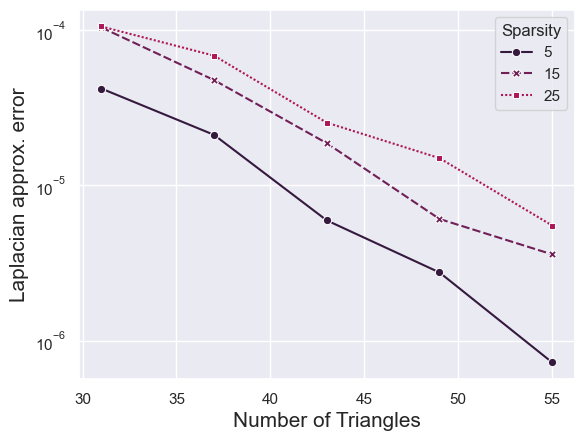

In [ ]:
sns.set(font_scale=1)
K0_coll3 = np.array([5, 17, 25])
mask = final["Sparsity"].isin(K0_coll3)
# Filter the original dataframe to retain only useful info
final2 = final[mask]
# Normalize the Laplacian approximation error
final2.reset_index()

final2["Sparsity"][final2["Sparsity"]==17]=15

my_plt = sns.lineplot(
    data=final2,
    x="Triangles",
    y="Error",
    hue="Sparsity",
    style="Sparsity",
    markers=True,
    palette=sns.color_palette("rocket"),
    errorbar=None,
    estimator=np.mean,
)

my_plt.set(yscale="log")
my_plt.set_ylabel("Laplacian approx. error", fontsize=15)
my_plt.set_xlabel(f"Number of Triangles", fontsize=15)
sns.set_style("whitegrid")
# pyl.setp(my_plt.get_legend().get_texts(), fontsize="14")
# pyl.setp(my_plt.get_legend().get_title(), fontsize="14")

C:\Users\engri\AppData\Local\Temp\ipykernel_39072\2900750772.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  my_plt = sns.lineplot(


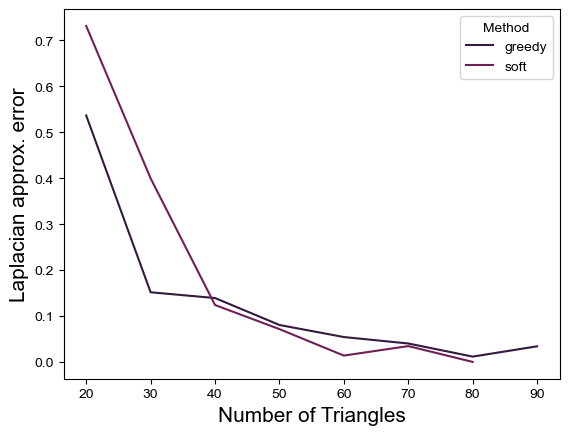

In [6]:
import seaborn as sns
import numpy as np
my_plt = sns.lineplot(
    data=final2,
    x="Triangles",
    y="Error",
    hue="Method",
    markers=True,
    palette=sns.color_palette("rocket"),
    errorbar=None,
    estimator=np.mean,
)

# my_plt.set(yscale="log")
my_plt.set_ylabel("Laplacian approx. error", fontsize=15)
my_plt.set_xlabel(f"Number of Triangles", fontsize=15)
sns.set_style("whitegrid")

In [9]:
final2['Error'] * 10**2

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.008868
        ...   
55    0.000484
56    0.000484
57    0.000000
58    0.000000
59    0.001175
Name: Error, Length: 150, dtype: float64

In [14]:
1/63*2

0.031746031746031744

In [12]:
final2["Error"]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000089
        ...   
55    0.000005
56    0.000005
57    0.000000
58    0.000000
59    0.000012
Name: Error, Length: 150, dtype: float64

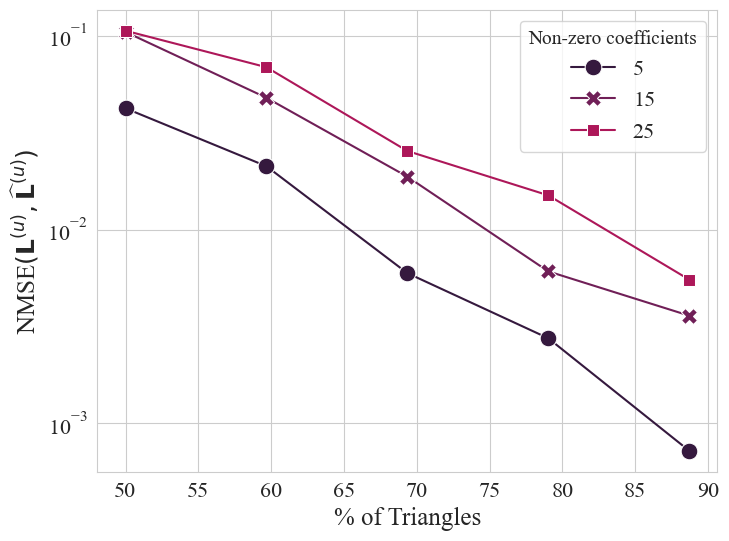

In [16]:
import matplotlib.pylab as pyl
final2['y_scaled'] = final2['Error'] * 10**3
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(8, 6))
my_plt = sns.lineplot(
    data=final2,
    x="\% of Triangles",
    y="y_scaled",
    hue="Sparsity",
    style="Sparsity",
    markers=True,
    markersize=12,
    palette=sns.color_palette("rocket"),
    errorbar=None,
    estimator=np.mean,
    dashes=False
)

my_plt.set(yscale="log")
my_plt.set_ylabel(r"NMSE$(\mathbf{L}^{(u)},\widehat{\mathbf{L}}^{(u)})$", fontsize=18)
# my_plt.set_ylabel("Laplacian approx. error", fontsize=15)
my_plt.set_xlabel(f"% of Triangles", fontsize=18)
my_plt.yaxis.label.set_rotation(90)

# pyl.setp(my_plt.get_legend().get_texts(), fontsize="14")
# pyl.setp(my_plt.get_legend().get_title(), fontsize="14")

plt.legend(
    title="Non-zero coefficients",  # Set custom legend title
    fontsize=16,             # Set legend font size
    title_fontsize=14        # Set title font size
)
# plt.savefig("LaplacianError.pdf", format="pdf")
plt.show()

In [8]:
with open(f"{path}\\results\\final\\random_sparsity25\\res_separated_T70.pkl", "rb") as fff:
    models70 = pickle.load(fff)
    dict_errors_comp = pickle.load(fff)

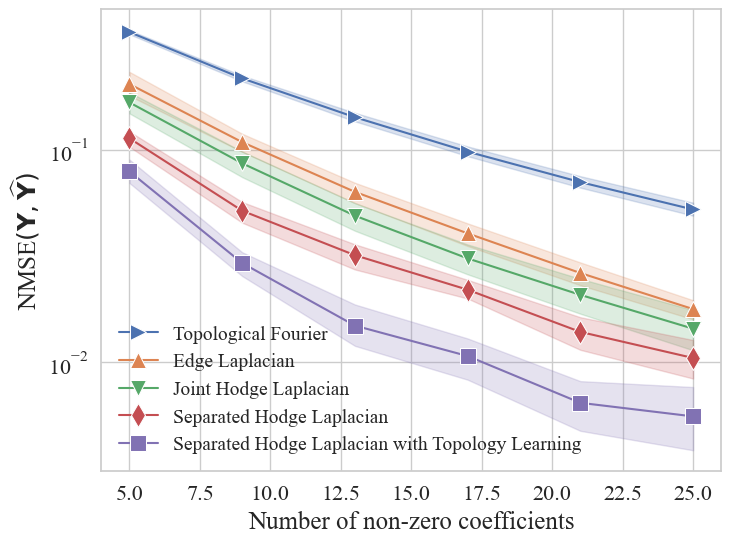

In [12]:
dict_types2 = {
    "fourier": "Topological Fourier",
    "edge": "Edge Laplacian",
    "joint": "Joint Hodge Laplacian",
    "separated": "Separated Hodge Laplacian",
    "complete": "Separated Hodge Laplacian with Topology Learning",
    "complete_pess": "Separated Hodge Laplacian with Pessimistic Topology Learning",
}
# TITLE = [dict_types[typ] for typ in dict_types.keys() if typ in dictionary_type][0]
res_df2 = pd.DataFrame()
for typ in dict_errors_comp.keys():
    tmp_df2 = pd.DataFrame(dict_errors_comp[typ][0])
    tmp_df2.columns = K0_coll2
    tmp_df2 = tmp_df2.melt(var_name="Sparsity", value_name="Error")
    tmp_df2["Method"] = dict_types2[typ] if typ in dict_types2.keys() else None
    pass
    res_df2 = pd.concat([res_df2, tmp_df2]).reset_index(drop=True)

markers = (
    [">", "^", "v", "d"]
    if len(dict_errors_comp.keys()) == 4
    else [">", "^", "v", "d", "s"]
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams["font.size"] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams["font.family"] = "Times New Roman"
my_plt = sns.lineplot(
    data=res_df2,
    x="Sparsity",
    y="Error",
    hue="Method",
    palette=sns.color_palette()[: len(dict_errors_comp)],
    markers=markers,
    markersize=12,
    dashes=False,
    style="Method",
)

my_plt.set(yscale="log")

my_plt.set_ylabel(r"NMSE$(\mathbf{Y},\widehat{\mathbf{Y}})$", fontsize=18)
my_plt.set_xlabel(f"Number of non-zero coefficients", fontsize=18)
handles, labels = my_plt.get_legend_handles_labels()
my_plt.legend(handles=handles[0:], labels=labels[0:])
plt.legend(
    fontsize=14,
    frameon=False,              # Display a frame around the legend
    framealpha=0.3              
)

plt.savefig("SignalError.pdf", format="pdf")
plt.show()

In [7]:
with open(f"{path}\\results\\real\\real_J2P3.pkl", "rb") as ffr:
    _ = pickle.load(ffr)
    dict_errors_real = pickle.load(ffr)

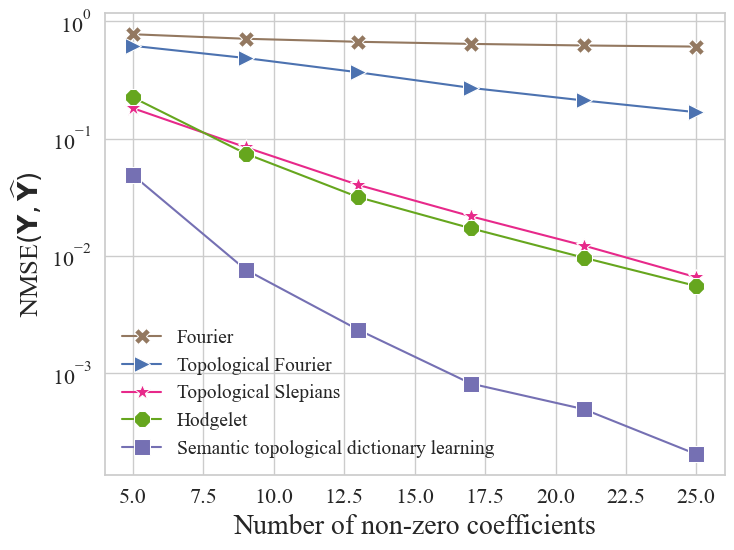

In [ ]:
sns.set(font_scale=1)
dict_types_real = {
    "classic_fourier": "Fourier",
    "fourier": "Topological Fourier [11]",
    "slepians": "Topological Slepians [41]",
    "wavelet": "Hodgelet [48]",
    # "separated": "Parametric Dictionary (Separated Hodge Laplacian)",
    "complete": "Parametric Dictionary with Topology learning",
    # "complete_pess": "Separated Hodge Laplacian with Pessimistic Topology learning",
}

res_df_real = pd.DataFrame()
for typ in dict_types_real.keys():
    tmp_df = pd.DataFrame(dict_errors_real[typ][0])
    tmp_df = tmp_df.transpose()
    tmp_df.columns = K0_coll2
    tmp_df = tmp_df.melt(var_name="Sparsity", value_name="Error")
    tmp_df["Method"] = dict_types_real[typ]
    res_df_real = pd.concat([res_df_real, tmp_df]).reset_index(drop=True)

markers = (
    ["p", ">", "*", "8", "d", "s"]
    if len(list(dict_errors_real.keys())) == 5
    else ["X", ">", "*", "8", "s"]
)
colors1 = sns.color_palette()[: len(list(dict_errors_real.keys())) - 1]
colors2 = sns.color_palette("Dark2", 5)
colors1[1] = colors2[-2]
colors1[2] = colors2[-1]
colors1 = [colors1[-1]] + colors1[:-1]
colors1[4] = colors2[-3]

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams["font.size"] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams["font.family"] = "Times New Roman"
my_plt = sns.lineplot(
    data=res_df_real,
    x="Sparsity",
    y="Error",
    hue="Method",
    palette=colors1,
    markers=markers,
    markersize=12,
    dashes=False,
    style="Method",
)
my_plt.set(yscale="log")
my_plt.set_ylabel(r"NMSE$(\mathbf{Y},\widehat{\mathbf{Y}})$", fontsize=19)
my_plt.set_xlabel(f"Number of non-zero coefficients", fontsize=20)
handles, labels = my_plt.get_legend_handles_labels()
my_plt.legend(handles=handles[0:], labels=labels[0:])
plt.legend(
    fontsize=14,
    frameon=False,              # Display a frame around the legend
    framealpha=0.3 
)
plt.savefig("SignalErrorReal.pdf", format="pdf")
plt.show()

In [262]:
with open(f"{path}\\results\\final\\random_sparsity25\\res_separated_T50.pkl", "rb") as fff:
    models50 = pickle.load(fff)

with open(f"{path}\\results\\final\\random_sparsity25\\res_separated_T20.pkl", "rb") as fff:
    models20 = pickle.load(fff)

### My models

- T20 S5
- T50 S5
- T50 S13

In [271]:
modc = models50['9,0']
modl = models50['9,2']
modu = models20['9,0']

### GT models

In [272]:
def fit_gt_model(k, p, G, Lu, data_path):

    with open(data_path, "rb") as f:
        data = pickle.load(f)

    init_params = {
        "J": 2,
        "P": 3,
        "c": data["c_true"][9],
        "epsilon": data["epsilon_true"][9],
        "true_prob_T": p,
        "sub_size": 100,
        "seed": 0,
        "n": 40,
        "K0": k,
        "p_edges": 0.162,
        "dictionary_type": "separated",
        "G_true": G,
    }

    algo_params = {
        "lambda_": 1e-7,
        "tol": 1e-7,
        "patience": 5,
        "max_iter": 100,
        "QP": True,
        "mode": "optimistic",
        "verbose": False,
    }

    gt_model = TopoSolver(
        X_train=data["X_train"][:, :, 9],
        X_test=data["X_test"][:, :, 9],
        Y_train=data["Y_train"][:, :, 9],
        Y_test=data["Y_test"][:, :, 9],
        **init_params,
    )

    gt_model.fit(
        Lu_true=Lu,
        init_mode="only_X",
        learn_topology=False,
        **algo_params,
    )

    return gt_model

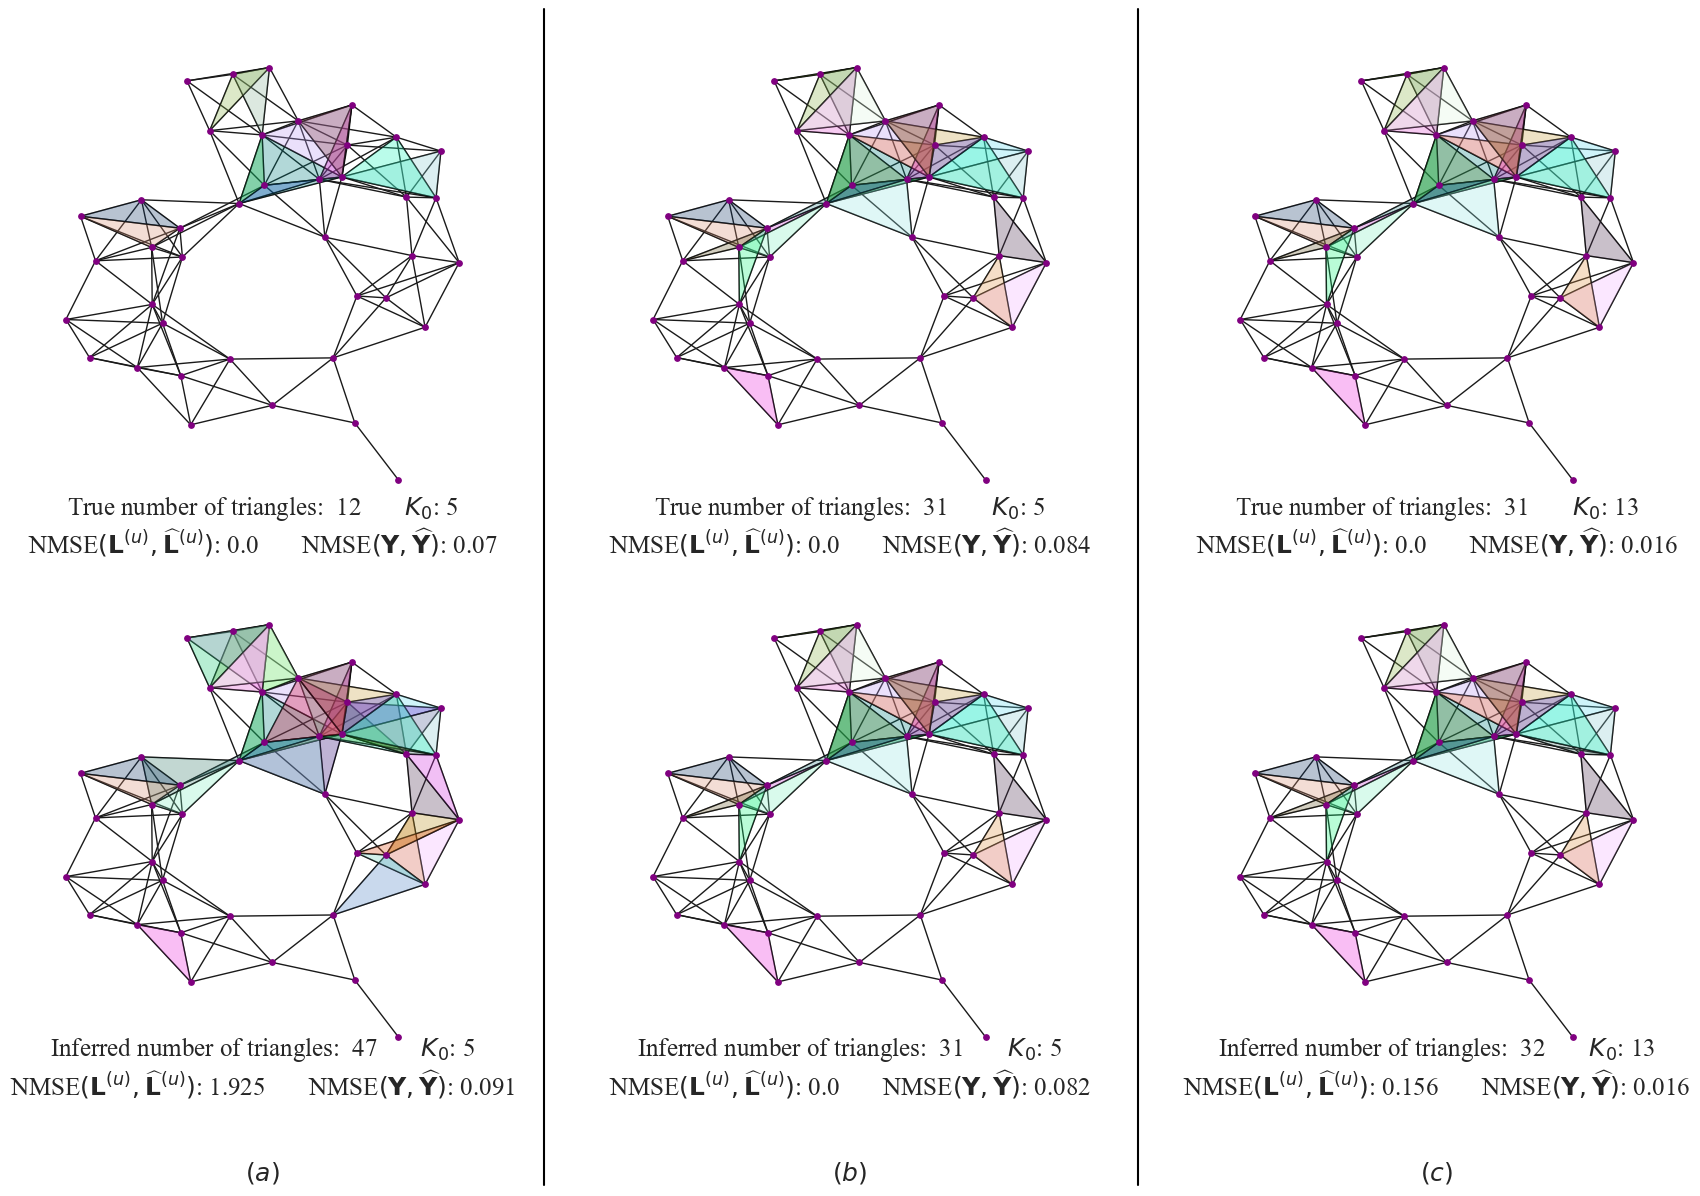

In [332]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
from topolearn.utils import save_plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from networkx.algorithms.cycles import find_cycle
import matplotlib.pylab as pyl

aux_gt = {}
idx = 0
my_models = [modu, modc, modl]
titles = [
    "True number of triangles: ",
    "Inferred number of triangles: ",
]

plt.rcParams["font.size"] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams["font.family"] = "Times New Roman"
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for k,p in zip([5,5,13], [0.2,0.5,0.5]):
    data_path = f"{path}\\synthetic_data\\random_sparsity25\\top_data_T{int(p*100)}.pkl"
    G_true = EnhancedGraph(
        n=40,
        p_edges=0.162,
        p_triangles=p,
        seed=0,
    )
    Lu_true, _, _ = G_true.get_laplacians(
        sub_size=100
    )

    B2 = G_true.get_b2()
    B2 = B2[: 100, :]
    B2 = B2[:, np.sum(np.abs(B2), 0) == 3]
    B2_true = B2 @ G_true.mask
    gt_model = fit_gt_model(k, p, G_true, Lu_true, data_path)
    opt_model = my_models[idx]
    
    topos = [gt_model, opt_model]
    num_triangles = [
        gt_model.get_numb_triangles(),
        opt_model.get_numb_triangles("optimistic"),
    ]
    incidence_mat = [B2_true, opt_model.B2]

    i = 0
    for ax, title in zip(axs, titles):
        A = G_true.get_adjacency()
        tmp_G = nx.from_numpy_array(A)
        pos = nx.kamada_kawai_layout(tmp_G)
        nx.draw(tmp_G, pos, with_labels=False, node_color="purple", node_size=15, ax=ax[idx])

        for triangle_index in range(B2_true.shape[1]):
            np.random.seed(triangle_index)
            color = np.random.rand(3)
            triangle_vertices = []

            for edge_index, edge in enumerate(tmp_G.edges):
                if edge_index < sub_size:
                    if incidence_mat[i][edge_index, triangle_index] != 0:
                        pos1 = tuple(pos[edge[0]])
                        pos2 = tuple(pos[edge[1]])
                        if pos1 not in triangle_vertices:
                            triangle_vertices.append(pos1)
                        if pos2 not in triangle_vertices:
                            triangle_vertices.append(pos2)
            if triangle_vertices != []:
                if i == 2:
                    num_triangles[-1] += 1
                triangle_patch = Polygon(
                    triangle_vertices,
                    closed=True,
                    facecolor=color,
                    edgecolor="black",
                    alpha=0.3,
                )
                ax[idx].add_patch(triangle_patch)

        txt = f"{title} {str(num_triangles[i])}       " + r"$K_0$" + f": {k}" + "\n" + r"NMSE$(\mathbf{L}^{(u)},\widehat{\mathbf{L}}^{(u)})$" + f": {np.round(topos[i].get_topology_approx_error(Lu_true, 3)/np.linalg.norm(Lu_true), 3)}       " + r"NMSE$(\mathbf{Y},\widehat{\mathbf{Y}})$" + f": {topos[i].get_test_error(3)}"
        if i==1:
            uss = -0.2
            if idx == 0:
                txt += "\n" "\n" "\n" + r"$\mathit{(a)}$"
            elif idx==1:
                txt += "\n" "\n" "\n" + r"$\mathit{(b)}$"
            else:
                txt += "\n" "\n" "\n" + r"$\mathit{(c)}$"
        else:
            uss = -0.06
        # ax[idx].set_title(title + str(num_triangles[i]))
        ax[idx].text(
            0.5,
            uss,
            txt,
            ha="center",
            transform=ax[idx].transAxes,
        )

        i += 1

    
    idx+=1

fig.add_artist(plt.Line2D([0.33, 0.33], [0.01, 0.99], transform=fig.transFigure, color="black", linewidth=1.5))  # First vertical line
fig.add_artist(plt.Line2D([0.66, 0.66], [0.01, 0.99], transform=fig.transFigure, color="black", linewidth=1.5))  # Second vertical line

# Add the horizontal line
# fig.add_artist(plt.Line2D([0.01, 0.99], [0.5, 0.5], transform=fig.transFigure, color="black", linewidth=2))  # Horizontal line

plt.tight_layout()
fig.savefig("output.pdf", format="pdf")

In [280]:
gt_models = [aux_gt['(5, 0.2)'], aux_gt['(5, 0.5)'], aux_gt['(13, 0.5)']]
my_models = [modu, modc, modl]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
from topolearn.utils import save_plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from networkx.algorithms.cycles import find_cycle
import matplotlib.pylab as pyl


def plot_learnt_topology_paper(
    G_true,
    Lu_true,
    B2_true,
    model_gt,
    model_opt,
    model_pess=None,
    sub_size=100,
    **kwargs,
):
    sns.set(font_scale=1.7)
    # if model_pess != None:

    #     topos = [model_gt, model_opt, model_pess]
    #     num_triangles = [
    #         model_gt.get_numb_triangles(),
    #         model_opt.get_numb_triangles("optimistic"),
    #         0,
    #     ]
    #     incidence_mat = [B2_true, model_opt.B2, model_pess.B2]
    #     titles = [
    #         "True number of triangles: ",
    #         "Inferred number of triangles: ",
    #         "Inferred number of triangles: ",
    #     ]
    #     plt.rcParams["font.size"] = 15
    #     plt.rcParams["font.family"] = "Times New Roman"
    #     _, axs = plt.subplots(1, 3, figsize=(16, 6))
    # else:
    topos = [gt_model, model_opt]
    num_triangles = [
        model_gt.get_numb_triangles(),
        model_opt.get_numb_triangles("optimistic"),
    ]
    incidence_mat = [B2_true, model_opt.B2]
    titles = [
        "True number of triangles: \n",
        "Inferred number of triangles: \n",
    ]
    plt.rcParams["font.size"] = 15
    plt.rcParams["font.family"] = "Times New Roman"
    _, axs = plt.subplots(1, 2, figsize=(12, 6))

    i = 0
    for ax, title in zip(axs, titles):
        A = G_true.get_adjacency()
        tmp_G = nx.from_numpy_array(A)
        pos = nx.kamada_kawai_layout(tmp_G)
        nx.draw(tmp_G, pos, with_labels=False, node_color="purple", node_size=15, ax=ax)

        for triangle_index in range(B2_true.shape[1]):
            np.random.seed(triangle_index)
            color = np.random.rand(3)
            triangle_vertices = []

            for edge_index, edge in enumerate(tmp_G.edges):
                if edge_index < sub_size:
                    if incidence_mat[i][edge_index, triangle_index] != 0:
                        pos1 = tuple(pos[edge[0]])
                        pos2 = tuple(pos[edge[1]])
                        if pos1 not in triangle_vertices:
                            triangle_vertices.append(pos1)
                        if pos2 not in triangle_vertices:
                            triangle_vertices.append(pos2)
            if triangle_vertices != []:
                if i == 2:
                    num_triangles[-1] += 1
                triangle_patch = Polygon(
                    triangle_vertices,
                    closed=True,
                    facecolor=color,
                    edgecolor="black",
                    alpha=0.3,
                )
                ax.add_patch(triangle_patch)

        ax.set_title(title + str(num_triangles[i]))
        ax.text(
            0.5,
            -0,
            r"NMSE$(\mathbf{L}^{(u)},\widehat{\mathbf{L}}^{(u)})$"
            + f": {np.round(topos[i].get_topology_approx_error(Lu_true, 4)/np.linalg.norm(Lu_true), 4)}  " 
            + r"NMSE$(\mathbf{Y},\widehat{\mathbf{Y}})$" 
            + f": {topos[i].get_test_error(4)}",
            ha="center",
            transform=ax.transAxes,
        )

        i += 1

    plt.tight_layout()


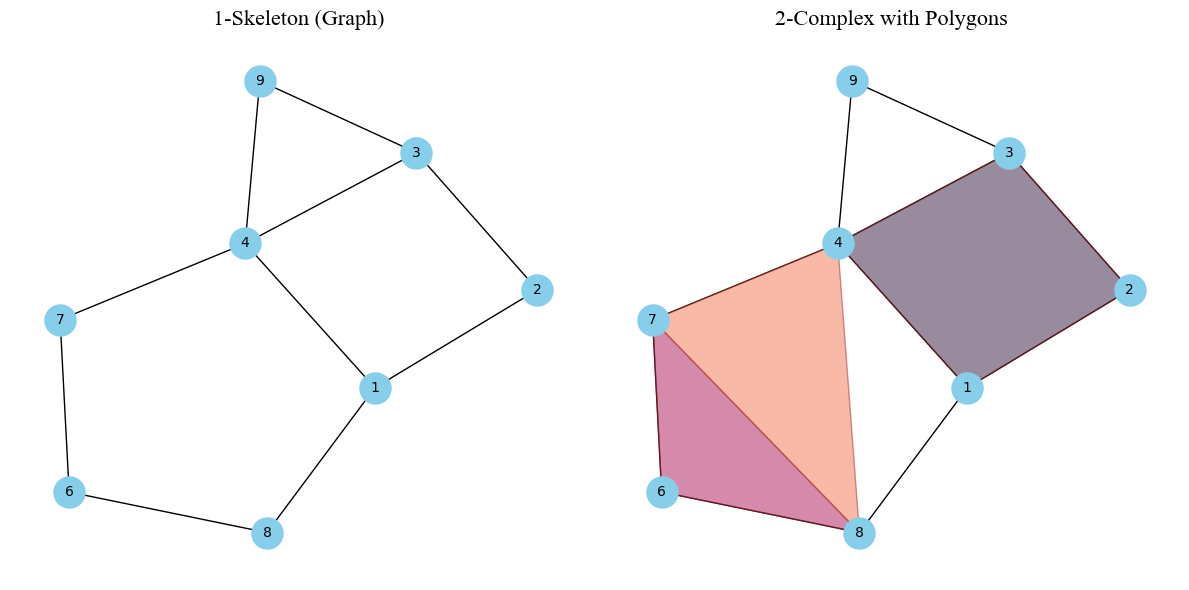

In [130]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import seaborn as sns

def plot_cell_complex():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Step 1: Create the graph (1-complex X1)
    G = nx.Graph()
    vertices = [1, 2, 3, 4,6 ,7, 8, 9]
    edges = [(1, 2), (2, 3), (3, 4), (4, 1), (6,7), (9, 3), (7,4), (6, 8), (1,8), (9,4)]
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)

    # Plot the graph
    pos = nx.kamada_kawai_layout(G)  # Use a circular layout for better visibility
    plt.rcParams["font.family"] = "Times New Roman"
    nx.draw(G, pos, ax=axs[0], with_labels=True, node_color='skyblue', edge_color='black', node_size=500, font_size=10)
    axs[0].set_title("1-Skeleton (Graph)", fontsize=16)

    # Step 2: Add 2-cells (polygons) to form X2
    polygons = [
        [pos[1], pos[2], pos[3], pos[4]],
        [pos[7], pos[6], pos[8]],
        [pos[7], pos[4], pos[8]],
        # [pos[6], pos[7], pos[4], pos[8]],
        # [pos[1], pos[3], pos[9], pos[4]]
        ]

    colors = sns.color_palette("rocket")
    
    # Plot the 2-complex
    nx.draw(G, pos, ax=axs[1], with_labels=True, node_color='skyblue', edge_color='black', node_size=500, font_size=10)
    patches = []
    for i, poly in enumerate(polygons):
        polygon = Polygon(poly, closed=True, edgecolor='brown', facecolor=colors[i*2], alpha=0.5)
        patches.append(polygon)
    
    patch_collection = PatchCollection(patches, match_original=True)
    axs[1].add_collection(patch_collection)
    axs[1].set_title("2-Complex with Polygons", fontsize=16)

    plt.tight_layout()
    fig.savefig("output.pdf", format="pdf")
    plt.show()

plot_cell_complex()


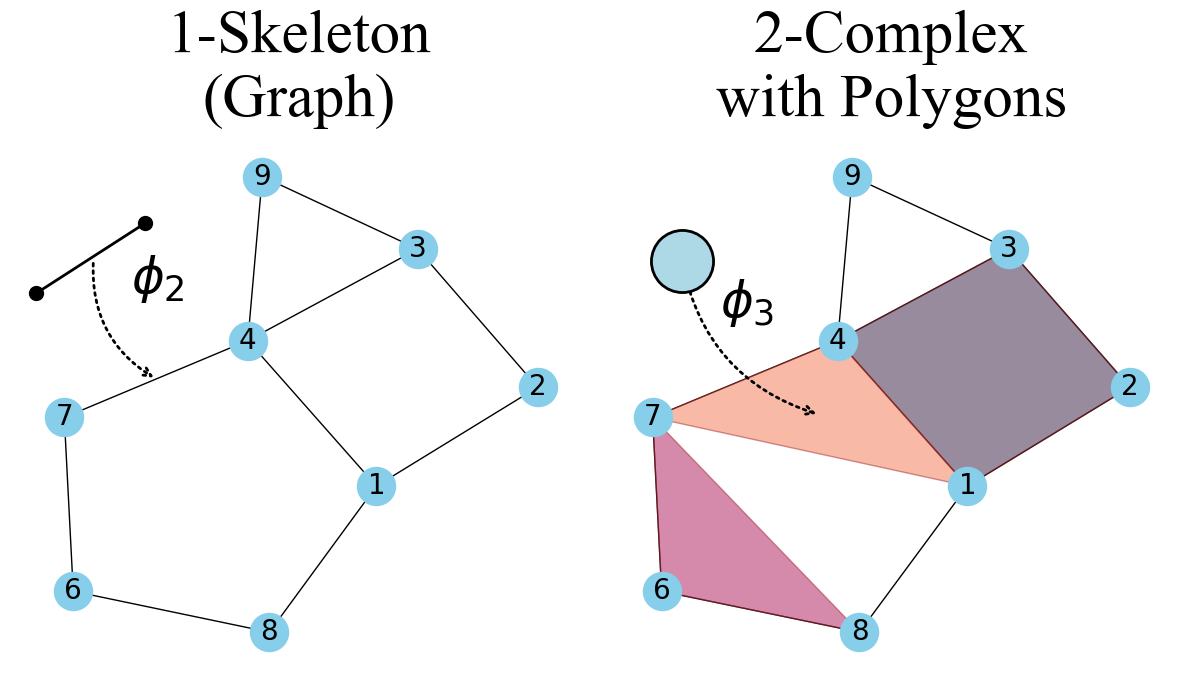

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.collections import PatchCollection
import numpy as np
import seaborn as sns

def plot_cell_complex():
    fig, axs = plt.subplots(1, 2, figsize=(12, 7))

    # Step 1: Create the graph (1-complex X1)
    G = nx.Graph()
    vertices = [1, 2, 3, 4, 6, 7, 8, 9]
    edges = [(1, 2), (2, 3), (3, 4), (4, 1), (6, 7), (9, 3), (7, 4), (6, 8), (1, 8), (9, 4)]
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)

    # Plot the graph
    pos = nx.kamada_kawai_layout(G)  # Use a circular layout for better visibility
    plt.rcParams["font.family"] = "Times New Roman"
    # nx.draw(G, pos, ax=axs[0], with_labels=True, node_color='skyblue', edge_color=None, node_size=750, font_size=20, width=0)
    # axs[0].set_title("0-Skeleton\n(Set of Nodes)", fontsize=35)

    # # Add the black point
    # black_point = np.array([-1, 0.5])  # Position of the black point
    # axs[0].scatter(*black_point, color='black', s=200, zorder=5)

    # # Add the curved, dotted arrow
    # target_node = 4  # Node the arrow points to
    # arrow = FancyArrowPatch(
    #     posA=black_point - np.array([-0.04, 0.05]), posB=pos[target_node] - np.array([0.03, 0.08]),
    #     connectionstyle="arc3,rad=0.3", arrowstyle="->", linestyle="dotted", color="black", linewidth=2, mutation_scale=15
    # )
    # axs[0].add_patch(arrow)

    # # Add the mapping label
    # axs[0].text(
    #     (black_point[0] + pos[target_node][0]) / 2 - 0.05,  # Midpoint + adjustment
    #     (black_point[1] + pos[target_node][1]) / 2,
    #     r"$\phi_1$", fontsize=36, color="black"
    # )

    # Plot the graph for the second subplot
    nx.draw(G, pos, ax=axs[0], with_labels=True, node_color='skyblue', edge_color='black', node_size=750, font_size=20)
    axs[0].set_title("1-Skeleton\n(Graph)", fontsize=35)

    # Step 2: Add 2-cells (polygons) to form X2
    polygons = [
        [pos[1], pos[2], pos[3], pos[4]],
        [pos[7], pos[6], pos[8]],
        [pos[7], pos[4], pos[1]],
    ]
    colors = sns.color_palette("rocket")
    
    # Plot the 2-complex
    nx.draw(G, pos, ax=axs[1], with_labels=True, node_color='skyblue', edge_color='black', node_size=750, font_size=20)
    patches = []
    for i, poly in enumerate(polygons):
        polygon = Polygon(poly, closed=True, edgecolor='brown', facecolor=colors[i * 2], alpha=0.5)
        patches.append(polygon)
    
    patch_collection = PatchCollection(patches, match_original=True)
    axs[1].add_collection(patch_collection)
    axs[1].set_title("2-Complex\nwith Polygons", fontsize=35)

    # Add the new mapping phi_2
    # Define the two black dots
    dot_1 = np.array([-0.5, 0.8])  # Position of the first dot
    dot_2 = np.array([-0.9, 0.5])  # Position of the second dot
    mean1 = np.mean([dot_1, dot_2], axis=0) + np.array([0.01,-0.01])
    mean2 = np.mean([pos[4], pos[7]], axis=0)
    # Plot the black dots
    axs[0].scatter(*dot_1, color='black', s=100, zorder=5)
    axs[0].scatter(*dot_2, color='black', s=100, zorder=5)

    # Connect the dots with a black edge
    axs[0].plot([dot_1[0], dot_2[0]], [dot_1[1], dot_2[1]], color='black', linewidth=2)

    # Add the arrow
    arrow_phi_2 = FancyArrowPatch(
        posA=mean1, posB=mean2, connectionstyle="arc3,rad=0.3", arrowstyle="->", linestyle="dotted", color="black", linewidth=2, mutation_scale=15
    )
    axs[0].add_patch(arrow_phi_2)

    # Add the mapping label
    axs[0].text(
        (dot_1[0] + dot_2[0]) / 2 + 0.15,  # Midpoint + adjustment
        (dot_1[1] + dot_2[1]) / 2 - 0.15,
        r"$\phi_2$", fontsize=36, color="black"
    )

    # Add the mapping phi_3 from colored ball to polygon
    # Define the position of the colored ball
    ball_pos = mean1
    ball_radius = 0.1  # Radius of the ball

    # Plot the colored ball
    axs[1].scatter(*ball_pos, color='lightblue', s=2000, zorder=5, ec='black', lw=2)

    # Define the target polygon for phi_3 (polygon 1)
    target_polygon = polygons[2]  # First polygon

    # Calculate the center of the target polygon (for the arrow direction)
    polygon_center = np.mean(target_polygon, axis=0)

    # Add a curved arrow from the ball to the polygon
    arrow_phi_3 = FancyArrowPatch(
        posA=ball_pos, posB=polygon_center, connectionstyle="arc3,rad=0.3", arrowstyle="->", linestyle="dotted", color="black", linewidth=2, mutation_scale=15
    )
    axs[1].add_patch(arrow_phi_3)

    axs[1].text(
        (dot_1[0] + dot_2[0]) / 2 + 0.15,  # Midpoint + adjustment
        (dot_1[1] + dot_2[1]) / 2 - 0.25,
        r"$\phi_3$", fontsize=36, color="black"
    )
    

    plt.tight_layout()
    fig.savefig("output.pdf", format="pdf")
    plt.show()

plot_cell_complex()


4-1 4-3

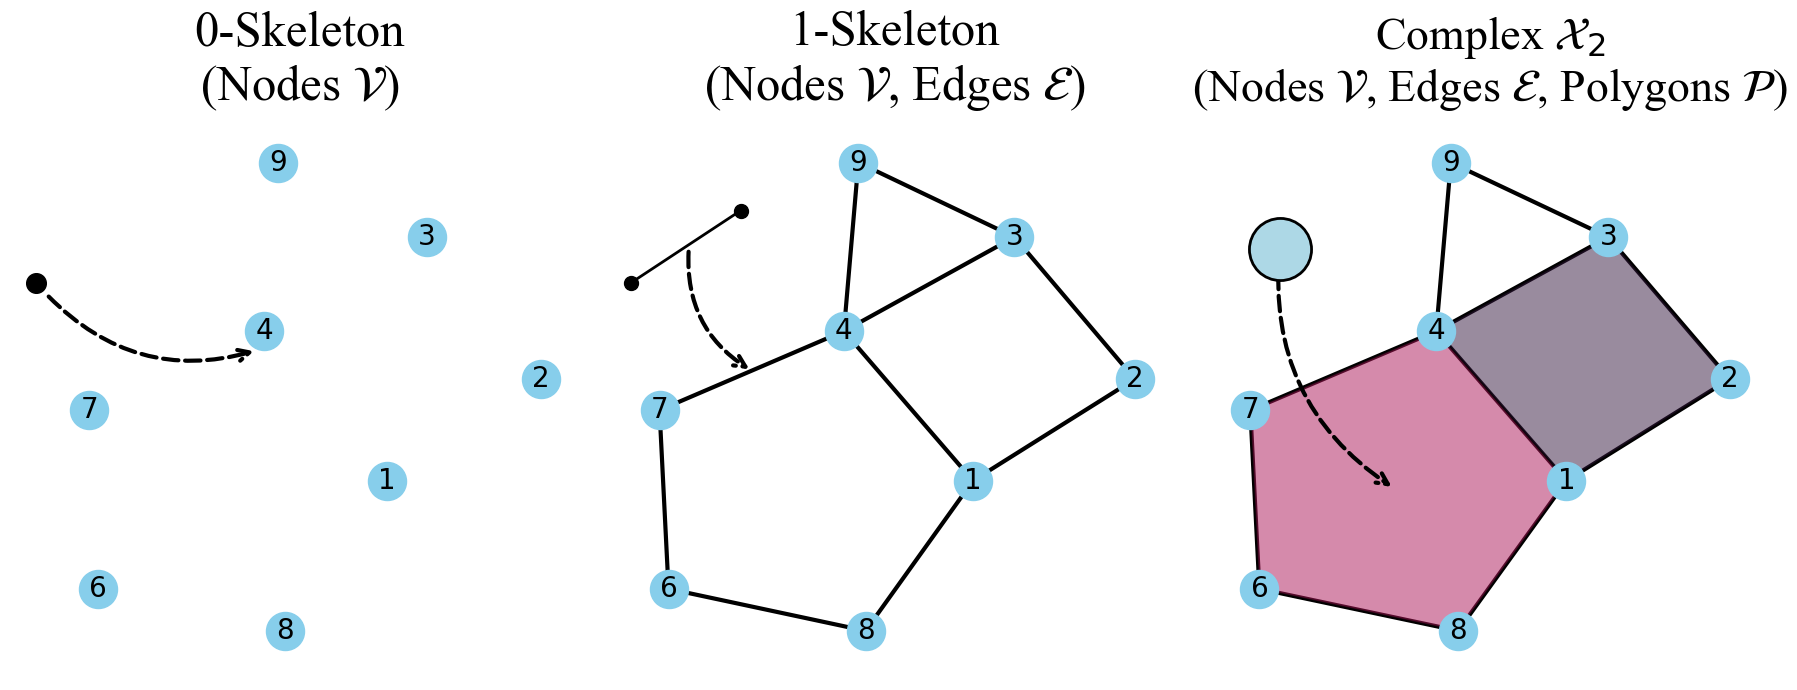

In [344]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.collections import PatchCollection
import numpy as np
import seaborn as sns

def plot_cell_complex():
    fig, axs = plt.subplots(1, 3, figsize=(18, 7))

    # Step 1: Create the graph (1-complex X1)
    G = nx.Graph()
    vertices = [1, 2, 3, 4, 6, 7, 8, 9]
    edges = [(1, 2), (2, 3), (3, 4), (4, 1), (6, 7), (9, 3), (7, 4), (6, 8), (1, 8), (9, 4)]
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)

    # Plot the graph
    pos = nx.kamada_kawai_layout(G)  # Use a circular layout for better visibility
    plt.rcParams["font.family"] = "Times New Roman"
    nx.draw(G, pos, ax=axs[0], with_labels=True, node_color='skyblue', edge_color=None, node_size=750, font_size=20, width=0)
    axs[0].set_title("0-Skeleton\n(Nodes "
                     + r'$\mathcal{V}$'
                     + ")", fontsize=35)

    # Add the black point
    black_point = np.array([-1, 0.5])  # Position of the black point
    axs[0].scatter(*black_point, color='black', s=200, zorder=5)

    # Add the curved, dotted arrow
    target_node = 4  # Node the arrow points to
    arrow = FancyArrowPatch(
        posA=black_point - np.array([-0.04, 0.05]), posB=pos[target_node] - np.array([0.03, 0.08]),
        connectionstyle="arc3,rad=0.3", arrowstyle="->", linestyle="--", color="black", linewidth=3, mutation_scale=20
    )
    axs[0].add_patch(arrow)

    # Add the mapping label
    # axs[0].text(
    #     (black_point[0] + pos[target_node][0]) / 2 - 0.35,  # Midpoint + adjustment
    #     (black_point[1] + pos[target_node][1]) / 2 + 0.25,
    #     r"$v_i \in \mathcal{V}$", fontsize=36, color="black"
    # )

    # Plot the graph for the second subplot
    nx.draw(G, pos, ax=axs[1], with_labels=True, node_color='skyblue', edge_color='black', node_size=750, font_size=20, width=3)
    axs[1].set_title("1-Skeleton\n(Nodes "
                     + r'$\mathcal{V}$'
                     + ", Edges "
                     + r'$\mathcal{E}$'
                     + ")", fontsize=35)

    # Step 2: Add 2-cells (polygons) to form X2
    polygons = [
        [pos[1], pos[2], pos[3], pos[4]],
        [pos[7], pos[6], pos[8], pos[1], pos[4]],
        # [pos[7], pos[4], pos[1]],
    ]
    colors = sns.color_palette("rocket")
    
    # Plot the 2-complex
    nx.draw(G, pos, ax=axs[2], with_labels=True, node_color='skyblue', edge_color='black', node_size=750, font_size=20, width=3)
    patches = []
    for i, poly in enumerate(polygons):
        polygon = Polygon(poly, closed=True, edgecolor='black', facecolor=colors[i * 2], alpha=0.5)
        patches.append(polygon)
    
    patch_collection = PatchCollection(patches, match_original=True)
    axs[2].add_collection(patch_collection)
    axs[2].set_title("Complex " 
                     + r'$\mathcal{X}_2$'
                     +"\n"
                     + "(Nodes "
                     + r'$\mathcal{V}$'
                     + ", Edges "
                     + r'$\mathcal{E}$'  
                     + ", Polygons "
                     + r'$\mathcal{P}$'
                     + ")", fontsize=33)

    # Add the new mapping phi_2
    # Define the two black dots
    dot_1 = np.array([-0.5, 0.8])  # Position of the first dot
    dot_2 = np.array([-0.9, 0.5])  # Position of the second dot
    mean1 = np.mean([dot_1, dot_2], axis=0) + np.array([0.01,-0.01])
    mean2 = np.mean([pos[4], pos[7]], axis=0)
    # Plot the black dots
    axs[1].scatter(*dot_1, color='black', s=100, zorder=5)
    axs[1].scatter(*dot_2, color='black', s=100, zorder=5)

    # Connect the dots with a black edge
    axs[1].plot([dot_1[0], dot_2[0]], [dot_1[1], dot_2[1]], color='black', linewidth=2)

    # Add the arrow
    arrow_phi_2 = FancyArrowPatch(
        posA=mean1, posB=mean2, connectionstyle="arc3,rad=0.3", arrowstyle="->", linestyle="--", color="black", linewidth=3, mutation_scale=20
    )
    axs[1].add_patch(arrow_phi_2)

    # Add the mapping label
    # axs[1].text(
    #     (dot_1[0] + dot_2[0]) / 2 - 0.25,  # Midpoint + adjustment
    #     (dot_1[1] + dot_2[1]) / 2 + 0.25,
    #     r"$e_k \in \mathcal{E}$", fontsize=36, color="black"
    # )

    # Add the mapping phi_3 from colored ball to polygon
    # Define the position of the colored ball
    ball_pos = mean1
    ball_radius = 0.1  # Radius of the ball

    # Plot the colored ball
    axs[2].scatter(*ball_pos, color='lightblue', s=2000, zorder=5, ec='black', lw=2)

    # Define the target polygon for phi_3 (polygon 1)
    target_polygon = polygons[1]  # First polygon

    # Calculate the center of the target polygon (for the arrow direction)
    polygon_center = np.mean(target_polygon, axis=0)

    # Add a curved arrow from the ball to the polygon
    arrow_phi_3 = FancyArrowPatch(
        posA=ball_pos, posB=polygon_center, connectionstyle="arc3,rad=0.3", arrowstyle="->", linestyle="--", color="black", linewidth=3, mutation_scale=20
    )
    axs[2].add_patch(arrow_phi_3)

    # axs[2].text(
    #     (dot_1[0] + dot_2[0]) / 2 - 0.25,  # Midpoint + adjustment
    #     (dot_1[1] + dot_2[1]) / 2 + 0.25,
    #     r"$p_j \in \mathcal{P}$", fontsize=36, color="black"
    # )
    

    plt.tight_layout()
    fig.savefig("gluing.pdf", format="pdf")
    plt.show()

plot_cell_complex()


2


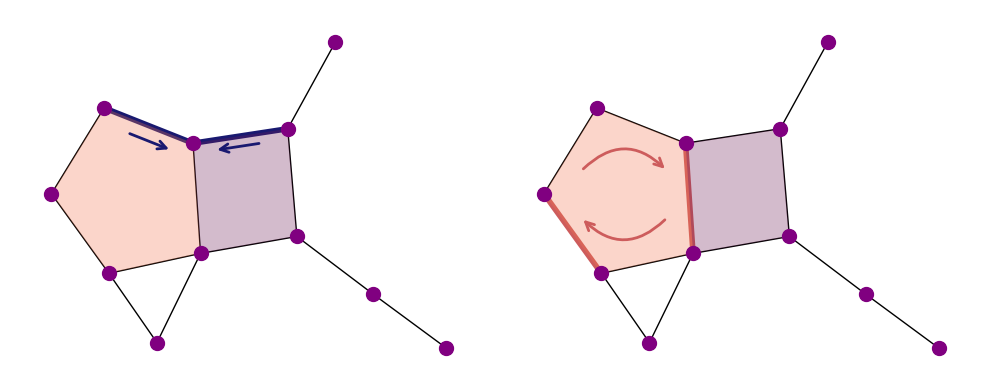

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import seaborn as sns

def plot_cell_complex():
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Step 1: Create the graph (1-complex X1)
    G = nx.Graph()
    vertices = [1, 2, 3, 4, 6, 7, 8, 9]
    edges = [(1, 2), (2, 3), (3, 4), (4, 1), (6, 7), (9, 3), (7, 4), (6, 8), (1, 8), (9, 4)]
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)

    # Plot the graph
    pos = nx.kamada_kawai_layout(G)  # Use a circular layout for better visibility
    plt.rcParams["font.family"] = "Times New Roman"
    
    special_edges_blue = [(4, 7), (4, 3)]  # Edges to be highlighted
    edge_colors = ['midnightblue' if edge in special_edges_blue or edge[::-1] in special_edges_blue else 'black' for edge in G.edges]
    edge_widths = [4 if edge in special_edges_blue or edge[::-1] in special_edges_blue else 1 for edge in G.edges]
    # Plot the graph
    pos = nx.kamada_kawai_layout(G)  # Use a circular layout for better visibility
    nx.draw(G, pos, ax=axs[0], with_labels=False, node_color='purple', edge_color=edge_colors, node_size=100, font_size=10, width=edge_widths)
    
    # Step 2: Add 2-cells (polygons) to form X2
    polygons = [
        [pos[1], pos[2], pos[3], pos[4]],
        [pos[7], pos[6], pos[8], pos[1], pos[4]],
        # [pos[6], pos[7], pos[4], pos[8]],
        # [pos[1], pos[3], pos[9], pos[4]]
        ]

    colors = sns.color_palette("rocket")
    colors = np.array(colors)[[1,4]]
    
    special_edges = [(4, 1), (6, 8)]  # Edges to be highlighted
    edge_colors = ['indianred' if edge in special_edges or edge[::-1] in special_edges else 'black' for edge in G.edges]
    edge_widths = [4 if edge in special_edges or edge[::-1] in special_edges else 1 for edge in G.edges]
    # Plot the 2-complex
    nx.draw(G, pos, ax=axs[1], with_labels=False, node_color='purple', edge_color=edge_colors, node_size=100, font_size=10, width=edge_widths)
    pos2 = nx.kamada_kawai_layout(G)

    # Step 2: Add 2-cells (polygons) to form X2
    polygons = [
        [pos[1], pos[2], pos[3], pos[4]],
        [pos[7], pos[6], pos[8], pos[1], pos[4]],
        # [pos[7], pos[4], pos[1]],
    ]
    colors = sns.color_palette("rocket")

    patches = []
    patches2 = []
    for i, poly in enumerate(polygons):
        polygon = Polygon(poly, closed=True, edgecolor=None, facecolor=colors[i], alpha=0.3)
        polygon2 = Polygon(polygons[i], closed=True, edgecolor=None, facecolor=colors[i*2], alpha=0.3)
        patches.append(polygon)
        patches2.append(polygon2)
    print(len(colors))
    patch_collection = PatchCollection(patches, match_original=True)
    patch_collection2 = PatchCollection(patches2, match_original=True)
    axs[1].add_collection(patch_collection)
    axs[0].add_collection(patch_collection2)

    k=1
    for edge in special_edges_blue:
        source, target = pos[edge[0]], pos[edge[1]]
        mid_point = (np.array(source) + np.array(target)) / 2  # Midpoint for arrow start
        arrow = FancyArrowPatch(
            posA=mid_point - np.array([k*0.1, 0.03]) ,  # Adjust for offset
            posB=source - np.array([k*0.1, 0.03]), connectionstyle="arc3,rad=0.", arrowstyle="->", color="midnightblue", linewidth=2, mutation_scale=15
        )
        axs[0].add_patch(arrow)
        k=-1
    
    poly_center = np.mean(polygons[1], axis=0)
    arrow1 = FancyArrowPatch(
        posA=poly_center + np.array([-0.2, 0.1]), posB=poly_center + np.array([0.2, 0.1]),
        connectionstyle="arc3,rad=-0.5", arrowstyle="->", color="indianred", linewidth=2, mutation_scale=15
    )
    arrow2 = FancyArrowPatch(
        posA=poly_center + np.array([0.2, -0.1]), posB=poly_center + np.array([-0.2, -0.1]),
        connectionstyle="arc3,rad=-0.5", arrowstyle="->", color="indianred", linewidth=2, mutation_scale=15
    )
    axs[1].add_patch(arrow1)
    axs[1].add_patch(arrow2)

    plt.tight_layout()
    fig.savefig("output.pdf", format="pdf")
    plt.show()

plot_cell_complex()


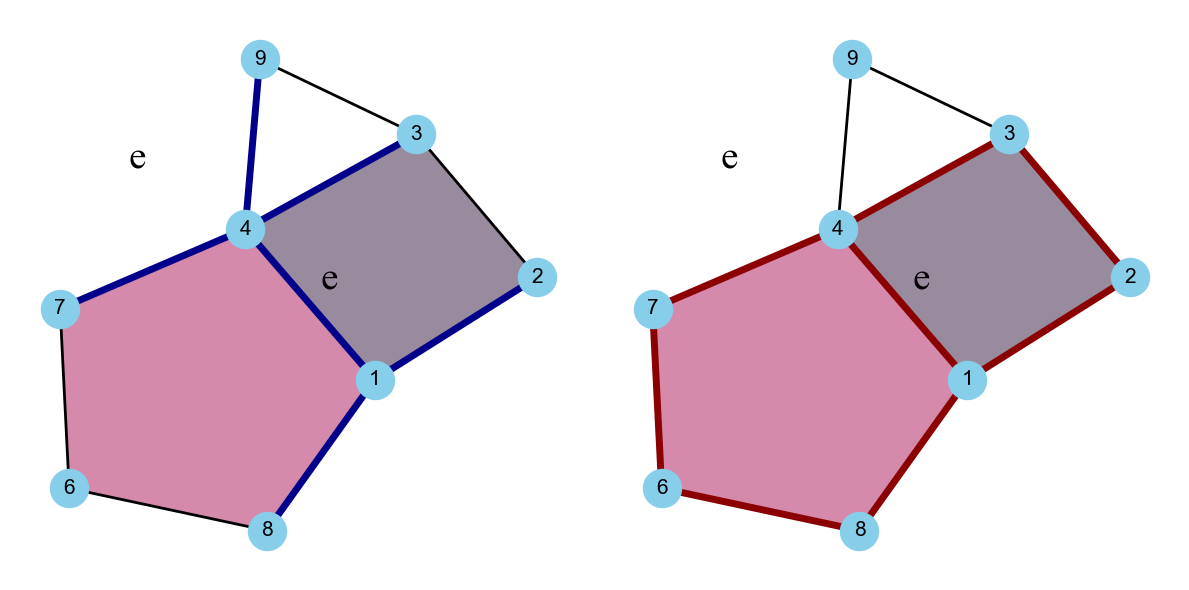

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import seaborn as sns

def plot_two_complex_with_highlight():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Step 1: Create the graph (1-complex X1)
    G = nx.Graph()
    vertices = [1, 2, 3, 4, 6, 7, 8, 9]
    edges = [(1, 2), (2, 3), (3, 4), (4, 1), (6, 7), (9, 3), (7, 4), (6, 8), (1, 8), (9, 4)]
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    pos = nx.kamada_kawai_layout(G)
    upper_edges = [(1, 4), (1, 8), (4, 7), (6, 7), (6, 8), (3, 4), (1, 2), (2, 3)]
    lower_edges = [(1, 4), (4, 7), (1, 8), (1, 2), (4, 9), (3, 4)]
    edge_colors1 = ['black' if edge not in lower_edges else 'darkblue' for edge in G.edges]
    edge_colors2 = ['black' if edge not in upper_edges else 'darkred' for edge in G.edges]
    width1 = [2 if edge not in lower_edges else 5 for edge in G.edges]
    width2 = [2 if edge not in upper_edges else 5 for edge in G.edges]

    polygons = [
        [pos[1], pos[2], pos[3], pos[4]],
        [pos[7], pos[6], pos[8], pos[1], pos[4]],
    ]
    colors = sns.color_palette("rocket")

    patches = []
    for i, poly in enumerate(polygons):
        polygon = Polygon(poly, closed=True, edgecolor=None, facecolor=colors[i * 2], alpha=0.5)
        patches.append(polygon)
    patch_collection = PatchCollection(patches, match_original=True)
    axs[0].add_collection(patch_collection)
    patches = []
    for i, poly in enumerate(polygons):
        polygon = Polygon(poly, closed=True, edgecolor='black', facecolor=colors[i * 2], alpha=0.5)
        patches.append(polygon)
    patch_collection = PatchCollection(patches, match_original=True)
    axs[1].add_collection(patch_collection)

    # First plot: Original 2-complex
    nx.draw(G, pos, ax=axs[0], with_labels=True, node_color='skyblue', edge_color=edge_colors1, 
            node_size=750, font_size=15, width=width1)
    # Second plot: Highlighted edge
    nx.draw(G, pos, ax=axs[1], with_labels=True, node_color='skyblue', edge_color=edge_colors2, 
            node_size=750, font_size=15, width=width2)

    emid_x = (pos[1][0] + pos[4][0]) / 2 +0.1
    emid_y = (pos[1][1] + pos[4][1]) / 2 +0.1
    Nu_x = (pos[1][0] + pos[4][0]) / 2 -0.6
    Nu_y = (pos[1][1] + pos[4][1]) / 2 +0.6
    axs[0].text(emid_x, emid_y, "e", fontsize=28, color='black', 
                horizontalalignment='right', verticalalignment='center')
    axs[1].text(emid_x, emid_y, 'e', fontsize=28, color='black', 
                horizontalalignment='right', verticalalignment='center')
    axs[0].text(Nu_x, Nu_y, r"e", fontsize=28, color='black', 
                horizontalalignment='right', verticalalignment='center')
    axs[1].text(Nu_x, Nu_y, 'e', fontsize=28, color='black', 
                horizontalalignment='right', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

plot_two_complex_with_highlight()


In [18]:
G.edges

NameError: name 'G' is not defined

In [1]:
import sys
import os
import pickle
from tqdm import tqdm
from topolearn import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")

import pandas as pd

dir_path = f'{os.getcwd()}\\results\\final\\random_sparsity25'
path = os.getcwd()

with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T70_pess.pkl", "rb") as fffr:
    models_max25_T70 = pickle.load(fffr)
    dict_errors_max25_T70 = pickle.load(fffr)

In [2]:
models_max25_T70

{(0, 0): [<topolearn.TopoSolver.TopoSolver at 0x14d2c8a6f70>],
 (0, 1): [<topolearn.TopoSolver.TopoSolver at 0x14e4de1b1f0>],
 (0, 2): [<topolearn.TopoSolver.TopoSolver at 0x14e4dd87700>],
 (0, 3): [<topolearn.TopoSolver.TopoSolver at 0x14e4dd64d00>],
 (0, 4): [<topolearn.TopoSolver.TopoSolver at 0x14e4dff0e80>],
 (0, 5): [<topolearn.TopoSolver.TopoSolver at 0x14e4dffdf40>]}

In [8]:
a=5
o=np.array([np.array(a) for a in models_max25_T70[(0,a)][0].train_history])
ll=[]
tmp=0
for a in models_max25_T70[(0,a)][0].train_history:
    tmp+=len(a)-1
    ll.append(tmp)
ll = np.unique(ll)
o=np.concatenate(o)

In [4]:
ll

array([15, 16, 22, 26, 28, 30, 33, 35, 38, 41, 46, 53, 56, 57])

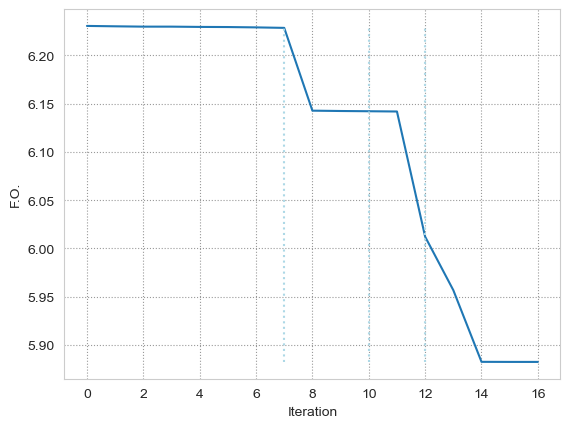

In [9]:
my_plt = sns.lineplot(o)
my_plt.set_ylabel("F.O.")
my_plt.set_xlabel("Iteration")
plt.vlines(
    x=ll,
    color="lightblue",
    linestyle="dotted",
    ymax=np.max(o),
    ymin=np.min(o),
)
plt.show()

Plot saved to c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\plots\final\max_sparsity20\topocp_learning_curve_T100_S20.png


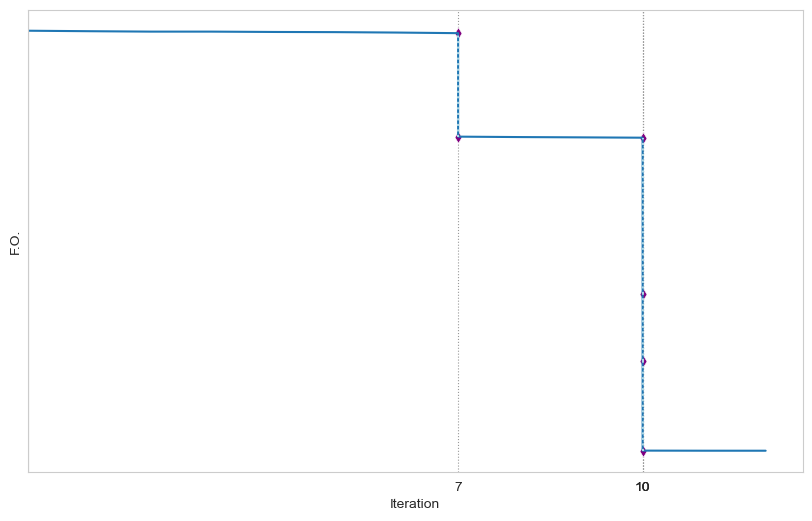

In [7]:
plot_changepoints_curve(models_max25_T70[(0, 5)][0].train_history, 62, yscale="normal", zoom_region=False)